In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad
# from math import log, exp, sqrt, pow
from matplotlib import rc
from matplotlib.colors import LogNorm
from scipy import interpolate

plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')

# constants
pi = 3.14159265359
alpha = 1 / 137.035999084  # fine structure constant
me = 510998.950  # e- mass [eV]
Mpl = 2e27  # planck mass [eV]
zeta3 = 1.202056903159594  # Riemann zeta(3)
amu = 931.494e6  # amu in eV

# conversion factors
s2eV = 6.582119569e-16  # Hz to eV
J2eV = 1.0 / 1.602176634e-19  # Joules to eV (1 / e)
m2eV = 1.973269804e-7  # m-1 to eV
K2eV = 8.617333262e-5  # Kelvin to eV
kg2eV = 5.609588604e35
T2eV = 2e2 # Tesla to eV2 conversion [eV2/T]
G2eV = 2e-2 # Gauss to eV2 conversion [eV2/G]

In [ ]:
# load the AGSS09 solar model data
# the AGSS09 data come from https://web.archive.org/web/20220616154019/https://wwwmpa.mpa-garching.mpg.de/~aldos/SSM/AGSS09/model_agss09.dat
# gaunt factor z1/z2 come from https://bitbucket.org/Jacetoto/bremsstrahlung/src/master/Database-th/
# the energy-dependent photoelectric cross section is getted by digitizing the figure

file = "AGSS09/"
# file = "/Users/yuangw/Documents/GitHub/chameleons/2406.01691/data/"
r = np.loadtxt(file + "r.dat")  # radial distance [eV-1]
T = np.loadtxt(file + "T.dat")  # solar temperature [eV]
rho = np.loadtxt(file + "rho.dat")  # solar density [eV4]
ne = np.loadtxt(file + "ne.dat")  # electron number density [eV3]
nbar = np.loadtxt(file + "nbar.dat")  # Z2-summed number density [eV3]
nbar2 = np.loadtxt(file + "nbar2.dat")  # Z2-summed number density minus electrons [eV3]
wp = np.loadtxt(file + "wp.dat")  # plasma frequency [eV]
nH = np.loadtxt(file + "nH.dat")  # H number density [eV3]
nHe3 = np.loadtxt(file + "nHe3.dat")  # He3 number density [eV3]
nHe4 = np.loadtxt(file + "nHe4.dat")  # He4 number density [eV3]


# Define the interpolation functions for the solar model data vs. radius in [eV]
rho_r = interpolate.interp1d(r, rho, fill_value=(0.0, 0.0), bounds_error=False)
T_r = interpolate.interp1d(r, T, fill_value=(0.0, 0.0), bounds_error=False)
ne_r = interpolate.interp1d(r, ne, fill_value=(0.0, 0.0), bounds_error=False)
wp_r = interpolate.interp1d(r, wp, fill_value=(0.0, 0.0), bounds_error=False)
nbar_r = interpolate.interp1d(r, nbar, fill_value=(0.0, 0.0), bounds_error=False)
nbar2_r = interpolate.interp1d(r, nbar2, fill_value=(0.0, 0.0), bounds_error=False)
nH_r = interpolate.interp1d(r, nH, fill_value=(0.0, 0.0), bounds_error=False)
nHe3_r = interpolate.interp1d(r, nHe3, fill_value=(0.0, 0.0), bounds_error=False)
nHe4_r = interpolate.interp1d(r, nHe4, fill_value=(0.0, 0.0), bounds_error=False)

z1 = np.loadtxt(file + "Z1.dat")  # gaunt factors for Z=1
z2 = np.loadtxt(file + "Z2.dat")  # gaunt factors for Z=2
print('z1',np.shape(z2),np.shape(z1))


z1 (501, 201) (501, 201)


### Primakoff Production from charged particles

Chameleon effective mass:
$$ m_\phi^2(\rho) = n( 1+n)\Lambda^{4+n}(\frac{\beta_m \rho (r)}{n m_{\rm Pl}\Lambda^{4+n}})^{\frac{2+n}{1+n}}$$
The Lagrangian terms relevant for Primakoff production are the following:
$$ \mathcal{L} \supset \frac{-\beta_{\gamma}}{4 M_{\rm Pl}} \phi F_{\mu\nu}F^{\mu\nu} - e A_{\mu}\bar{\psi}\gamma^{\mu}\psi $$
* These allow for production of scalars through the interactions of photons with charged particles (electrons and ions) in the solar plasma, by the process $\gamma + Z e \to Ze + \phi$. (Here,we have ignored the disformal coupling, leaving the study of this production channel for future works.)

The total production rate of scalars/chameleons from Primakoff process is:
$$ \frac{1}{\beta_\gamma^2}\frac{\mathrm{d}\dot N}{\mathrm{d}\omega} = \frac{\alpha}{8\pi M_\mathrm{Pl}^2} \int_0^{R_\odot} \frac{r^2 \mathrm{d}r}{e^{\omega/T} - 1} \frac{\omega^2 k_\phi}{k_\gamma} \mathcal{I}(u,v) \sum_i Z_i^2 n_i  $$
where:
$$ u = \frac{k_\gamma}{2 k_\phi} + \frac{k_\phi}{2 k_\gamma}, \qquad  v = \frac{\kappa^2}{2 k_\gamma k_\phi}  $$
$$ k_\gamma = \sqrt{\omega^2 - m_\gamma^2}, \qquad k_\phi = \sqrt{\omega^2 - m^2}  $$
and the Debye screening scale $\kappa$ satisfy $\kappa^2 = \frac{4 \pi \alpha}{T} \sum_i Z_i^2 n_i$

/var/folders/jg/fgqgnyxs1tlcbr5x6bxs_gl40000gn/T/ipykernel_30317/996933042.py:43: RuntimeWarning: overflow encountered in exp
  bose = nbarr / (np.exp(w / Tr) - 1)


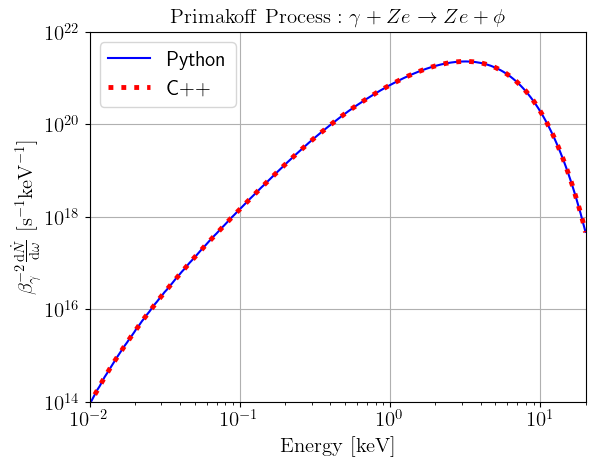

In [3]:
n=1
E = 2.4e-3   #eV
Bm = 100

rSolar = 6.957e8 / m2eV  # solar radius [eV-1]
radius = rSolar * np.logspace(-2, 0, 200)  # [eV-1]

#chameleon model params n, Bm (matter coupling), assume rho dominated by matter density
def mCham2(r, Bm):  # effective mass square, Eq.18 in 2406.01691
    """Chameleon mass squared as a function of solar radius."""
    E4n = E**(4 + n)
    x = Bm * rho_r(r) / (n * Mpl * E4n)
    x = np.clip(x, 1e-30, None) # set minimum value, avoid log(0) or negative value  
    return n * (n + 1) * E4n * np.power(x, (n + 2) / (n + 1))

# Define curlyI
def curlyI(u, v):
    return (u*u - 1) / v * np.log((u - 1) / (u + 1)) - ((u + v)**2 - 1) / v * np.log((u + v - 1) / (u + v + 1)) - 2

# Define curlyI approximation near u => 1
def curlyIapprox(u, v):
    return u*u / v - (v + 2) * np.log(v / (v + 2)) - 2

def T_integrand(r, w, Bm):
    """Differential scalar production rate on Earth d2N/dw divided by beta_gamma^2"""
    Tr = np.clip(T_r(r), 1, None)  # avoid division by zero
    ner = np.clip(ne_r(r), 1e-5, None)
    nbarr = np.clip(nbar_r(r), 1e-5, None)

    mg2 = 4 * pi * alpha * ner / me
    ms2 = mCham2(r, Bm)
    if w**2 <= mg2 or w**2 <= ms2:
        return 0.0

    K2 = 8 * pi * alpha * nbarr / Tr
    kgamma = np.sqrt(np.abs(w**2 - mg2))
    kphi = np.sqrt(np.abs(w**2 - ms2))
    uArg = kgamma / (2 * kphi) + kphi / (2 * kgamma)
    vArg = K2 / (2 * kphi * kgamma)

    Iuv = curlyI(uArg, vArg) if uArg >= 1.01 else curlyIapprox(uArg, vArg)
    factor = alpha/ (8 * Mpl**2 * pi)
    bose = nbarr / (np.exp(w / Tr) - 1)
    
    kernel = factor * r**2 * bose * w**2 * kphi/ kgamma * Iuv
    return kernel *1e3/s2eV  # factor 1e3/s2eV convert [eV/eV] to [s-1 keV-1]

T_integrand_vec = np.vectorize(T_integrand)

def T_solarIntg(w, Bm):
    """Integrate T_integrand over the solar radius."""
    return np.trapz(T_integrand_vec(radius, w, Bm), radius)  # integrate over radius

w_array = np.logspace(1, 4.3, 200)  # [eV]
spectrum = np.array([T_solarIntg(wi, Bm=100) for wi in w_array])

Pdata = np.loadtxt("/Users/yuangw/Documents/GitHub/chameleons/AGSS09/Primakoff.csv")
Priene, Pri = Pdata[:, 0], Pdata[:, 1]  # Primakoff cross section [eV-1]
Primakoff = interpolate.interp1d(Priene, Pri, fill_value="extrapolate", bounds_error=False)

plt.plot(w_array/1e3, spectrum, color='blue', label='Python')
plt.plot(w_array/1e3, Primakoff(w_array/1e3), color='red', linestyle=':', linewidth=3.5, label='C++')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0.01, 20)
plt.ylim(1e14, 1e22)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'${\rm Energy~[keV]}$', fontsize=15)
plt.ylabel(r'$\beta_\gamma^{-2}\frac{\mathrm{d}\dot N}{\mathrm{d}\omega}~[{\rm s^{-1} keV^{-1}}]$', fontsize=15)
plt.title(r'${\rm Primakoff~Process:~}\gamma + Z e \to Ze + \phi$', fontsize=15)
plt.grid()
plt.legend(fontsize=15)
plt.savefig('plots/primakoff.pdf')
plt.show()

### Chameleon production in Bulk Magnetic Fields

We integrate over the phase space to obtain the total production rate $\dot{N}$:
$$ \mathrm{d} \dot N = \mathrm{d}V \frac{\mathrm{d}^3k_\phi}{(2\pi)^3} \Gamma_\phi^{\operatorname{prod}} = \mathrm{d}V \frac{\mathrm{d}^3k_\phi}{(2\pi)^3}  (\frac{\beta_\gamma B_\perp}{M_\mathrm{Pl}})^2 \frac{k_\phi^2}{\vert\omega^2 - k_\gamma^2 - \pi_\gamma \vert^2} \frac{\Gamma_\gamma}{e^{\omega/T} -1}  $$
Hence 
$$  \frac{1}{\beta_\gamma^2}\frac{\mathrm{d}\dot N}{\mathrm{d}\omega} \!=\! \frac{2}{\pi M_\mathrm{Pl}^2} \!\int_0^{R_\odot} \!\!\mathrm{d}r \frac{r^2 B_\perp^2(r)}{e^{\omega/T(r)} - 1} \frac{\omega(\omega^2 - m^2)^{3/2}}{(m_\gamma^2 - m^2)^2 \!+\! (\omega \Gamma_\gamma)^2} \Gamma_\gamma  $$
we have assumed the following form:
$$\Gamma_\gamma = \Gamma^{\rm abs}-\Gamma^{\rm pro} = \frac{64\pi^2\alpha^3}{3m_e^2\omega^3} \sqrt{\frac{m_e}{2\pi T}} n_e \left( 1\!-\!e^{-\omega/T} \right)\sum_i Z^2 n_i F_i + \frac{8\pi\alpha^2}{3m_e^2} n_e   $$
where the sum is over all ion species in the Sun, and $F_i$ is the thermally-averaged Gaunt factor for species $i$.

* In Tom's C++ code, he use 'pow(w\*w - ms2, 3/2)' to calculate $(\omega^2-m^2)^{3/2}$, which actually is equal to 'pow(w\*w - ms2, 1.0)'
* the way of selecting Gaunt factor has problem, replace $z_{\rm Tom}[a][a]$ with  $z_{\rm right}[a][b] $
* the production induced by bulk magnetic field $B(r)$ should replace $B_{\perp}=B(r)$ with $B_{\perp}^2 = 2*B(r)^2/3$

/var/folders/jg/fgqgnyxs1tlcbr5x6bxs_gl40000gn/T/ipykernel_30317/4293159754.py:94: RuntimeWarning: overflow encountered in exp
  factor2 = (np.power( (mg2 - ms2), 2.0) + (w*w*G*G) ) * (np.exp(w/Tr) - 1.0)
/var/folders/jg/fgqgnyxs1tlcbr5x6bxs_gl40000gn/T/ipykernel_30317/4293159754.py:120: RuntimeWarning: overflow encountered in exp
  factor2 = (np.power( (mg2 - ms2), 2.0) + (w*w*G*G) ) * (np.exp(w/Tr) - 1.0)


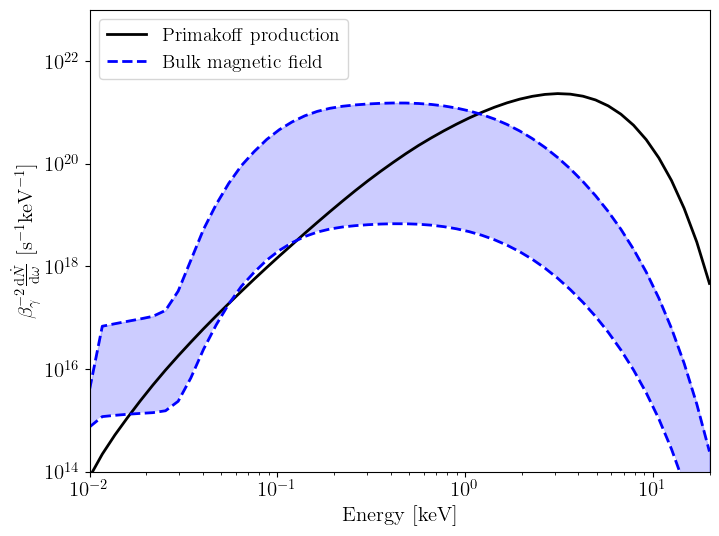

In [12]:
# solar magnetic field parameters
B0 = 3000 * T2eV  # radiative zone max B [eV2]  200*T2eV;
B1 = 50 * T2eV  # tachocline max B [eV2]  4*T2eV;//
B2 = 4 * T2eV  # outer region max B [eV2]  3*T2eV;//
Bf1 = [3000.0*T2eV, 50.0*T2eV, 4.0*T2eV]  # [eV2]
Bf2 = [200.0*T2eV,  4.0*T2eV,  3.0*T2eV]

Rrad = 0.712   
Rtach = 0.732   
Rupper = 0.96   
dtach = 0.02   
dupper = 0.035  
radius1 = rSolar * np.linspace(0.001, 1.0, 500)


def Bsolar(rr, B):
    r = rr / rSolar  # radius dimensionless
    if r < Rrad:  # radiative zone
        lam = 10 * Rrad +1
        x = r / Rrad
        return B[0] * (1 + lam) * np.power(1 + 1 / lam, lam) * x**2 * np.power(1 - x**2, lam)
    
    elif Rtach - dtach < r < Rtach + dtach: # tachocline
        return B[1] * (1 - ((r - Rtach) / dtach)**2.0)

    elif Rupper - dupper < r < Rupper + dupper: # outer region
        return B[2] * (1 - ((r - Rupper) / dupper)**2.0)

    else:
        return 0.0
   
Bsolar_vec1 = np.vectorize(lambda r: Bsolar(r, Bf1))
Bsolar_vec2 = np.vectorize(lambda r: Bsolar(r, Bf2))

def GammaPhoton(r, w, g1, g2):  # absorption-production, paper 2406.01691 Eq.A20
    Tr = np.clip(T_r(r), 1e-5, None)  # avoid division by zero or negative values
    ner = np.clip(ne_r(r), 1e-5, None)
    nHr = np.clip(nH_r(r), 1e-5, None)
    nHe3r = np.clip(nHe3_r(r), 1e-5, None)
    nHe4r = np.clip(nHe4_r(r), 1e-5, None)
    
    p1 = 64 * pi**2 * np.power(alpha, 3)
    p2 = 3 * np.power(me, 2) * np.power(w, 3)
    p3 = me * np.power(ner, 2) / (2 * pi * Tr)
    p4 = 1 - np.exp(-w / Tr)
    p5 = 8 * pi * np.power(alpha, 2) * ner / (3 * np.power(me, 2))
    ions = (nHr * g1) + g2 * (4 * nHe4r + 4 * nHe3r)  # sum of ion densities
    return p1/p2 * np.sqrt(p3) * p4 * ions + p5


####Find the nearest two temperatures T1, T2 in the table that bracket the actual physical temperature T_r(r) at that radius.
####But the table gives Θ = T / mₑ, so to compare with a physical T, you must divide by me when searching
def selectG(r, w):
    """Selects Gaunt factor from matrix and computes Gamma (eV)."""
    a1 = a2 = b1 = b2 = 1
    Tr = np.clip(T_r(r), 1e-10, None)  # avoid division by zero

    # convert Gaunt factor Theta to T in eV, Find indices for temperature interpolation
    xx1 = np.append(0, z1[0])
    xx2 = np.append(0, z2[0])
    for i in range(1, 200):
        if xx1[i] < Tr/me < xx1[i + 1]:
            a1 = i
        if xx2[i] < Tr/me < xx2[i + 1]:
            a2 = i

    # Find indices for frequency interpolation
    for i in range(1, 500):
        if (z1[i][0] * Tr) < w < (z1[i + 1][0] * Tr):
            b1 = i
        if (z2[i][0] * Tr) < w < (z2[i + 1][0] * Tr):
            b2 = i

    g1 = z1[b1][a1]
    g2 = z2[b2][a2]
    # g1 = z1[a1][a1]
    # g2 = z2[a2][a2]
    return GammaPhoton(r, w, g1, g2)


def B_integrand1(r, w, Bm):  # [eV Bg-2] Eq.7 in paper 2406.01691
    """Differential scalar production rate due to magnetic field."""
    Tr = np.clip(T_r(r), 1e-5, None)  # avoid division by zero
    ner = np.clip(ne_r(r), 1e-10, None)
    
    mg2 = 4 * pi * alpha * ner / me
    ms2 = mCham2(r, Bm)
    if w**2 <= mg2 or w**2 <= ms2 or mg2 == ms2:
        return 0.0
    
    B = Bsolar_vec1(r)
    G = selectG(r, w)
    factor1 = w* np.power(w*w - ms2, 1.5) * G
    factor2 = (np.power( (mg2 - ms2), 2.0) + (w*w*G*G) ) * (np.exp(w/Tr) - 1.0)
    kernel = 2 * r**2.0 * B**2.0/(pi*Mpl*Mpl)  * factor1/(factor2)
    return kernel * 1e3/s2eV  # factor 1e3/s2eV convert [eV/eV] to [s-1 keV-1]

B_integrand_vec1 = np.vectorize(B_integrand1)

def B_solarIntg1(w, Bm):
    """Integrate B_integrand over the solar radius."""
    # integrand = lambda r_val: B_integrand(r_val, w, Bm)
    # result, _ = quad(integrand, 0.01 * rSolar, rSolar)
    result = np.trapz(B_integrand_vec1(radius1, w, Bm), radius1)  # integrate over radius
    return result

def B_integrand2(r, w, Bm):  # [eV Bg-2] Eq.7 in paper 2406.01691
    """Differential scalar production rate due to magnetic field."""
    Tr = np.clip(T_r(r), 1e-5, None)  # avoid division by zero
    ner = np.clip(ne_r(r), 1e-10, None)
    
    mg2 = 4 * pi * alpha * ner / me
    ms2 = mCham2(r, Bm)
    if w**2 <= mg2 or w**2 <= ms2 or mg2 == ms2:
        return 0.0
    
    B = Bsolar_vec2(r)
    G = selectG(r, w)
    factor1 = w* np.power(w*w - ms2, 1.5) * G
    factor2 = (np.power( (mg2 - ms2), 2.0) + (w*w*G*G) ) * (np.exp(w/Tr) - 1.0)
    kernel = 2 * r**2.0 * B**2.0/(pi*Mpl*Mpl)  * factor1/(factor2)
    return kernel * 1e3/s2eV  # factor 1e3/s2eV convert [eV/eV] to [s-1 keV-1]

B_integrand_vec2 = np.vectorize(B_integrand2)

def B_solarIntg2(w, Bm):
    """Integrate B_integrand over the solar radius."""
    # integrand = lambda r_val: B_integrand(r_val, w, Bm)
    # result, _ = quad(integrand, 0.01 * rSolar, rSolar)
    result = np.trapz(B_integrand_vec2(radius1, w, Bm), radius1)  # integrate over radius
    return result

plt.figure(figsize=(8, 6))
Pdata = np.loadtxt("/Users/yuangw/Documents/GitHub/chameleons/AGSS09/Primakoff.csv")
Priene, Pri = Pdata[:, 0], Pdata[:, 1]  # Primakoff cross section [eV-1]
Primakoff = interpolate.interp1d(Priene, Pri, fill_value="extrapolate", bounds_error=False)
plt.plot(w_array/1e3, Primakoff(w_array/1e3), color='black', linestyle='-', linewidth=2.0, label=r'${\rm Primakoff~production}$')


w_array = np.logspace(1, 4.3, 50)  # [eV]
Bspectrum1 = np.array([B_solarIntg1(wi, Bm=100) for wi in w_array])
Bspectrum2 = np.array([B_solarIntg2(wi, Bm=100) for wi in w_array])
plt.plot(w_array/1e3, Bspectrum1, color='blue', linestyle="--", linewidth=2, label=r'${\rm Bulk~magnetic~field}$')
plt.plot(w_array/1e3, Bspectrum2, color='blue', linestyle="--", linewidth=2 )
plt.fill_between(w_array/1e3, Bspectrum2, Bspectrum1, color='blue', alpha=0.2)
plt.fill_between(w_array/1e3, 10, Bspectrum2, color='white')

# Bdata1 = np.loadtxt("/Users/yuangw/Documents/GitHub/chameleons/AGSS09/Blow.csv")
# Bdata2 = np.loadtxt("/Users/yuangw/Documents/GitHub/chameleons/AGSS09/Bup.csv")
# B1x, B1y = Bdata1[:, 0], Bdata1[:, 1]  # bulk magnetic field [eV-1]
# Blow = interpolate.interp1d(B1x, B1y, fill_value="extrapolate", bounds_error=False)
# B2x, B2y = Bdata2[:, 0], Bdata2[:, 1]  # bulk magnetic field [eV-1]
# Bup = interpolate.interp1d(B2x, B2y, fill_value="extrapolate", bounds_error=False)
# plt.plot(B2x, B2y, color='orange', label=r'${\rm Bulk~Magnetic~B_{up}}$', linestyle='-')
# plt.plot(B1x, B1y, color='orange', label=r'${\rm Bulk~Magnetic~B_{low}}$', linestyle='--')
# plt.fill_between(B2x, B2x*0.1, Bup(B2x), color='orange', alpha=0.3)
# plt.fill_between(B1x, B1x*0.1, Blow(B1x), color='white')


plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0.01, 20)
plt.ylim(1e14, 1e23)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'${\rm Energy~[keV]}$', fontsize=15)
plt.ylabel(r'$\beta_\gamma^{-2}\frac{\mathrm{d}\dot N}{\mathrm{d}\omega}~[{\rm s^{-1} keV^{-1}}]$', fontsize=15)
# plt.title(r'${\rm Bulk~Magnetic~Field~Production}$', fontsize=15)
# plt.grid()
plt.legend(loc='upper left', fontsize=14)
plt.savefig('plots/spectrum.pdf')
plt.show()

/var/folders/jg/fgqgnyxs1tlcbr5x6bxs_gl40000gn/T/ipykernel_30317/4293159754.py:94: RuntimeWarning: overflow encountered in exp
  factor2 = (np.power( (mg2 - ms2), 2.0) + (w*w*G*G) ) * (np.exp(w/Tr) - 1.0)
/var/folders/jg/fgqgnyxs1tlcbr5x6bxs_gl40000gn/T/ipykernel_30317/996933042.py:43: RuntimeWarning: overflow encountered in exp
  bose = nbarr / (np.exp(w / Tr) - 1)


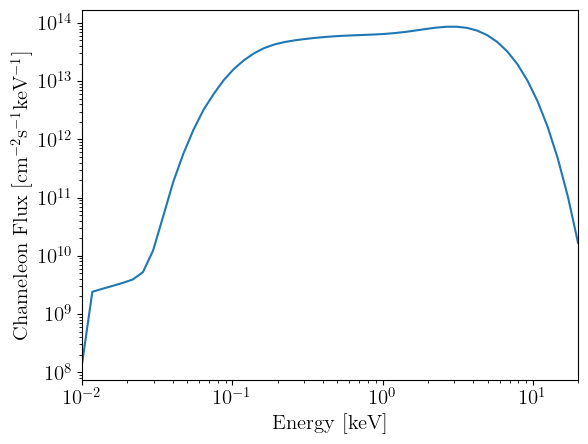

In [13]:
## Conversion units
pc    = 3.086e18     # cm
gkeV  = 1.782662e-30 # conversion from g to keV
year  = 3.15e7       # conversion from year to s
NXe   = 4.58644e21   # Number of Xe atoms per g
conv  = 10**6*year   # conversion from (g*s)^-1 to (year*ton)^-1
tXE   = 1.042e6      # XENON1T target in g

Dist = 1.496e13  ## cm, average distance between Earth and Sun
gg = 10.0  ## beta_gamma, chameleon coupling with photon
ge = 2.0   ## beta_matter, chameleon coupling with matter/electron

def flux_earth(w, Bm):
    "the differential flux at Earth in cm^-2 s^-1 keV^-1"
    bulk = B_solarIntg1(w, Bm)
    primakoff = T_solarIntg(w, Bm)
    return 100**gg *(bulk + primakoff)/(4*pi*Dist*Dist)

flux_earth = np.vectorize(flux_earth)
w_array = np.logspace(1, 4.3, 50)  # [eV]
flux = np.array([flux_earth(wi, Bm=100) for wi in w_array])

plt.plot(w_array/1e3, flux)
plt.xlabel(r'${\rm Energy~[keV]}$', fontsize=15)
plt.ylabel(r'${\rm Chameleon~Flux~[cm^{-2}s^{-1} keV^{-1}}]$', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0.01, 20)
# plt.ylim(1e8, 1e15)
plt.xscale('log')
plt.yscale('log')
plt.savefig('plots/flux.pdf',bbox_inches='tight')
plt.show()

The resulting differential event rate per unit production energy $\omega$ for chameleon in the XENON1T/XENONnT detector is given by:
$$\left ( \frac{\mathrm{d}R}{\mathrm{d}\omega} \right )_{\rm th} = \epsilon(\omega)\,\int \frac{\mathrm{d}R_0(\omega_R)}{\mathrm{d}\omega_R}\,\Theta(\omega-\omega_R)\,\mathrm{d}\omega_R   $$
where $\Theta(\omega)$ is the energy resolution of the detector and $\epsilon(\omega)$ is the XENON1T detection efficiency. The ``raw'' differential event rate per unit production energy of chameleons in the XENON1T detector is given by:
$$\frac{\mathrm{d}R_0(\omega)}{\mathrm{d}\omega} = N_{\rm Xe}\,\frac{\mathrm{d}\Phi_{\rm Earth}}{\mathrm{d}\omega}\,\sigma_{\phi e} =  N_{\rm Xe} \sigma_{\phi e} \frac{1}{4\pi D^2} (\frac{\mathrm{d}\dot{N}_{P}}{\mathrm{d}\omega} +  \frac{\mathrm{d}\dot{N}_{B}}{\mathrm{d}\omega} ) $$
where the number of atoms per ton of xenon is $N_{\rm Xe} = 4.6\times 10^{27}{\rm \,ton}^{-1}$, so that the differential event rate is expressed in units of ${\rm ton}^{-1}\,{\rm yr}^{-1}\,{\rm keV}^{-1}$

* Regarding the $\sigma_{\phi e}$, we only consider conformal term:
$\sigma_{\phi e, conf} = \frac{\beta_e^2 \omega^2}{2\pi \alpha M_{\rm Pl}^2} \sigma_{\rm photon}$, and ignore the disformal term $\sigma_{\phi e, dis} = \frac{m_e^2 \omega^4}{8\pi^2 M_e^8}$.